## Goal
#### Associated git sha of `vispz/numerai` github repo `11c74ffc`
In the notebook `task7b-ensembling-model-for-each-target`, we predicted using the models from each of the 36x3, `target x cv` split on the first half of the train+test split `test1`.  We will now use these prediction columns to and select the best target-models to ensemble on.


### Methodology
We will use 2 methods of feature selection
 * Elastic-Net
 * Recursive feature selection with shallow gbt.


#### Previous notebook saved data format
  ``` python
  {
      "cv_predcols_map": [
          ["pred_arthur_v4_20_cv0", "pred_nomi_v4_20_cv0", ...],  # cv 0
          ["pred_arthur_v4_20_cv1", "pred_nomi_v4_20_cv1", ...],  # cv 1
          ["pred_arthur_v4_20_cv2", "pred_nomi_v4_20_cv2", ...],  # cv 2
      ],
      "cv_to_val_test_map": [
          # cv 0
          {"val": pd.DataFrame([era, features, pred_cols]),
           "test": pd.DataFrame([era, features])},
          {"val": DF, "test": DF},  # cv 1
          {"val": DF, "test": DF},  # cv 2
          
      ]
  }
  ```

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

from importlib import reload
import logging
reload(logging)
import logging
logging.basicConfig(level=logging.INFO)

import glob
import numpy as np
import datetime
import json
import os
import os.path
from os.path import join
import warnings
import flatdict
import pandas as pd
import mlflow
import gc
import plotly.graph_objects as go
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.offline as pyo
import itertools as it
from typing import List
import copy

import utils as ut

from pprint import pprint, pformat
from tqdm.notebook import tqdm

from utils import ERA_COL, TARGET_COL


pyo.init_notebook_mode()
pd.options.mode.chained_assignment = None  # default='warn'
# Filter the setuptools UserWarning until we stop relying on distutils
warnings.filterwarnings("ignore")
DF = pd.DataFrame
sns.set_theme()

## 1. Constants

In [2]:
LOCAL = True
if LOCAL:
    ML_TRACKING_SERVER_URI = "http://127.0.0.1:5000"
    AWS_CREDENTIALS_FILE = "~/.aws/personal_credentials"
else:
    ML_TRACKING_SERVER_URI = "http://18.218.213.146:5500/"
    AWS_CREDENTIALS_FILE = "~/.aws/credentials"
EXPERIMENT_NAME = f"ensemble_tgts_for_cyrus_2023-04-26_19h-36m"
DATA_PATH = "./data/"
VAL_PRED_S3_PATH = (
    "s3://numerai-v1/experiments/"
    "ensemble_tgts_for_cyrus_2023-04-26_19h-36m/"
    "ckpt1_cv_val_preds_no_feats.pkl"
)
log = ut.Logger(root_dir="./")

EXPT_LOCAL_DIR = os.path.join(DATA_PATH, "experiments", EXPERIMENT_NAME)
MODEL_DIR = join(EXPT_LOCAL_DIR, "models")
for fld in [EXPT_LOCAL_DIR, MODEL_DIR]:
    os.makedirs(fld, exist_ok=True)
    log.info(f"Making {fld}")
    
log.info(f"{EXPERIMENT_NAME=}")
log.info(f"{VAL_PRED_S3_PATH=}")

[2023-04-28 08:48:58]  Making ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m
[2023-04-28 08:48:58]  Making ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/models
[2023-04-28 08:48:58]  EXPERIMENT_NAME='ensemble_tgts_for_cyrus_2023-04-26_19h-36m'
[2023-04-28 08:48:58]  VAL_PRED_S3_PATH='s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl'


In [3]:
log.info(f"{TARGET_COL=}")

[2023-04-28 08:48:59]  TARGET_COL='target_cyrus_v4_20'


## 2. Download data and load up the model predns on val data

In [4]:
mlflow.set_tracking_uri(ML_TRACKING_SERVER_URI)
try:
    cv_expt_id = mlflow.create_experiment(name=EXPERIMENT_NAME)
except Exception:
    cv_expt_id = mlflow.get_experiment_by_name(name=EXPERIMENT_NAME).experiment_id
log.info(f"{EXPERIMENT_NAME=}, {cv_expt_id=}")

[2023-04-28 08:49:00]  EXPERIMENT_NAME='ensemble_tgts_for_cyrus_2023-04-26_19h-36m', cv_expt_id='849708612397429268'


In [5]:
ut.download_s3_file(
    local_path=EXPT_LOCAL_DIR,
    s3_path=VAL_PRED_S3_PATH,
    aws_credential_fl=AWS_CREDENTIALS_FILE,
)

[2023-04-28 08:49:00]  Loading aws credenitals from ~/.aws/personal_credentials...
[2023-04-28 08:49:00]  Would have downloaded s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl to ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl. But ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl exists. Will not download again ...


In [6]:
cv_valpreds_orig = ut.unpickle_obj(fl=join(EXPT_LOCAL_DIR, "ckpt1_cv_val_preds_no_feats.pkl"))

In [7]:
# HACK: Accidentally duplicated the columns twice, only include them once instead
NUM_TARGETS = 36
cv_valpreds = copy.deepcopy(cv_valpreds_orig)
cv_valpreds["cv_predcols_map"] = [
    cv_pc[:NUM_TARGETS]
    for cv_pc in cv_valpreds["cv_predcols_map"]
]

In [8]:
gc.collect()

23383

In [9]:
split = 0
cv_valpreds["cv_to_val_test_map"][split]["val"].head()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,pred_target_ben_v4_20_cv0,pred_target_ben_v4_60_cv0,pred_target_alan_v4_20_cv0,pred_target_alan_v4_60_cv0,pred_target_paul_v4_20_cv0,pred_target_paul_v4_60_cv0,pred_target_george_v4_20_cv0,pred_target_george_v4_60_cv0,pred_target_william_v4_20_cv0,pred_target_william_v4_60_cv0
id,,,,,,,,,,,,,,,,,,,,,
n001f768affa1cc2,1.0,1.0,0.75,0.75,0.75,1.0,0.75,1.0,0.75,1.0,...,0.493943,0.475514,0.494528,0.478933,0.454020,0.450485,0.455395,0.436630,0.499045,0.476133
n002cc5b29f8705f,0.5,0.5,0.50,0.25,0.50,0.5,0.50,0.5,0.50,0.5,...,0.495377,0.509305,0.496175,0.490550,0.474163,0.483902,0.486066,0.495735,0.498365,0.507437
n00361f031876c68,0.5,0.5,0.50,0.50,0.50,0.5,0.50,0.5,0.50,0.5,...,0.488254,0.486235,0.493248,0.480340,0.482077,0.454602,0.475474,0.466946,0.485363,0.479478
n00385e672d049e6,0.0,0.0,0.25,0.25,0.50,0.0,0.25,0.0,0.25,0.0,...,0.491807,0.488826,0.511420,0.501787,0.455790,0.444844,0.475221,0.449966,0.494380,0.498582
n00503d13b28d441,0.5,0.5,0.50,0.50,0.25,0.5,0.50,0.5,0.50,0.5,...,0.524468,0.498629,0.533116,0.521875,0.532201,0.516652,0.525540,0.507236,0.533293,0.513035


In [10]:
cv_valpreds["cv_to_val_test_map"][split]["test"].head()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,pred_target_ben_v4_20_cv0,pred_target_ben_v4_60_cv0,pred_target_alan_v4_20_cv0,pred_target_alan_v4_60_cv0,pred_target_paul_v4_20_cv0,pred_target_paul_v4_60_cv0,pred_target_george_v4_20_cv0,pred_target_george_v4_60_cv0,pred_target_william_v4_20_cv0,pred_target_william_v4_60_cv0
id,,,,,,,,,,,,,,,,,,,,,
n00164cb9c597154,1.00,1.00,0.50,0.75,0.50,1.00,0.5,1.00,0.5,0.75,...,0.462140,0.453088,0.488272,0.476812,0.432102,0.393445,0.457779,0.419536,0.475697,0.458260
n0028609fde88b03,1.00,1.00,0.75,0.75,0.50,0.75,0.5,0.75,0.5,1.00,...,0.525290,0.538764,0.500456,0.505370,0.526002,0.543837,0.532270,0.560145,0.518491,0.522983
n002bfff507f118e,0.50,0.50,0.50,0.50,0.25,0.50,0.5,0.25,0.5,0.25,...,0.496298,0.508979,0.501143,0.494654,0.529000,0.535165,0.514607,0.524918,0.508741,0.520494
n002d0d989a01142,0.75,0.75,0.50,0.75,0.50,0.75,0.5,0.75,0.5,0.75,...,0.501930,0.506025,0.514477,0.505899,0.552279,0.565865,0.508856,0.536651,0.522526,0.516137
n00620b3b0a59ab1,0.75,0.75,0.50,1.00,0.50,0.75,0.5,0.50,0.5,0.75,...,0.479739,0.485134,0.504286,0.501196,0.535674,0.544112,0.506822,0.511838,0.491546,0.476516


## 3. Compute baseline metrics which is simply taking the average

In [11]:
def extract_cols_like(all_cols, match_cols):
    return [
        col for col in all_cols
        if any(partial in col for partial in match_cols)
    ]

In [12]:
import re
def refmt_predcols(col):
    """Use regex to extract col name 
    pred_target_arthur_v4_20_cv1 -> pred_arthur_v4_20"""
    return re.search(r"pred_target_(\w+)_cv", col).group(1)

In [13]:
def score_baselines(
    cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="",
):
    """
    :param predcols_subset: This could be a partial name like ['arthur_v4_20', 'nomi_v4_60']
    """
    cv = len(cv_valpreds["cv_predcols_map"])
    # xval metrics, xval ensemble columns, xval prediction value describe
    bl_cv_metrics, bl_cv_predcols, cv_pred_descs = [], [], []
    for split, predcols, val_test_map in tqdm(
        zip(
            range(cv),
            cv_valpreds["cv_predcols_map"],
            cv_valpreds["cv_to_val_test_map"],
        ),
        desc="CV split",
        total=cv,
    ):
        train_df, test_df = val_test_map["val"], val_test_map["test"]
        log.info(
            f"{split=}, {train_df[predcols].shape=}, {train_df.era.min()=}, "
            f"{train_df.era.max()=}, {train_df.era.nunique()=}",
        )
        ensmbl_predcol = f"ensemble_{baseline_name}_cv{split}"
        if predcols_subset is None:
            chosen_fts = predcols
        else:
            chosen_fts = extract_cols_like(all_cols=predcols, match_cols=predcols_subset)
        log.info(f"Chosen {len(chosen_fts)} features: \n{chosen_fts}")
        test_df[ensmbl_predcol] = agg_fn(test_df[chosen_fts], axis=1)
        bl_cv_metrics.append(
            ut.validation_metrics(
                validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
            ),
        )
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    log.info("Prediction distribution")
    display(pd.concat(cv_pred_descs, axis=1))
    baseline_metrics = ut.to_cv_agg_df(bl_cv_metrics)
    display(ut.fmt_metrics_df(baseline_metrics))
    return baseline_metrics

### 3.1 Average all 36 target models

In [14]:
bl_allpred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="allpreds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-28 08:49:08]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-04-28 08:49:08]  Chosen 36 features: 
['pred_target_arthur_v4_20_cv0', 'pred_target_arthur_v4_60_cv0', 'pred_target_thomas_v4_20_cv0', 'pred_target_thomas_v4_60_cv0', 'pred_target_cyrus_v4_20_cv0', 'pred_target_cyrus_v4_60_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_caroline_v4_60_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_sam_v4_60_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_xerxes_v4_60_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_nomi_v4_60_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_tyler_v4_60_cv0', 'pred_target_victor_v4_20_cv0', 'pred_target_victor_v4_60_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_ralph_v4_60_cv0', 'pred_target_waldo_v4_20_cv0', 'pred_target_waldo_v4_60_cv0', 'pred_target_jerome_v4_20_cv0', 'pred_target_jerome_v4_60_cv0', 'pred_target_janet_v4_20_cv0', 'pred_target_janet_v4_60

,ensemble_allpreds_mean_cv0,ensemble_allpreds_mean_cv1,ensemble_allpreds_mean_cv2
count,590333.000000,571414.000000,507469.000000
mean,0.499084,0.501019,0.499891
std,0.016239,0.018883,0.025984
min,0.403835,0.392828,0.361744
25%,0.488993,0.488816,0.483469
50%,0.499610,0.501000,0.499875
75%,0.509779,0.513161,0.516336
max,0.573454,0.602210,0.649094


,mean,std,sharpe
ensemble_allpreds_mean_cv0,2.56%,2.14%,119.57%
ensemble_allpreds_mean_cv1,2.84%,1.85%,153.61%
ensemble_allpreds_mean_cv2,2.71%,1.78%,152.79%
cv_mean,2.71%,1.92%,141.99%
cv_low,2.55%,1.70%,120.01%
cv_high,2.86%,2.14%,163.97%
cv_std,0.14%,0.19%,19.42%


In [15]:
len([c for c in cv_valpreds["cv_to_val_test_map"][0]["test"].columns if c.startswith("pred_target_")])

36

### 3.2 Average top 8 target models

In [16]:
bl_top8pred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=[
    "pred_target_cyrus_v4_20",
    "pred_target_ralph_v4_20",
    "pred_target_sam_v4_20",
    "pred_target_xerxes_v4_20",
    "pred_target_caroline_v4_20",
    "pred_target_waldo_v4_20",
    "pred_target_nomi_v4_20",
    "pred_target_tyler_v4_20",
    ],
    agg_fn=np.mean,
    baseline_name="top8preds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-28 08:49:09]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-04-28 08:49:09]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_waldo_v4_20_cv0']
[2023-04-28 08:49:10]  split=1, train_df[predcols].shape=(571392, 36), train_df.era.min()=556, train_df.era.max()=671, train_df.era.nunique()=116
[2023-04-28 08:49:10]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv1', 'pred_target_caroline_v4_20_cv1', 'pred_target_sam_v4_20_cv1', 'pred_target_xerxes_v4_20_cv1', 'pred_target_nomi_v4_20_cv1', 'pred_target_tyler_v4_20_cv1', 'pred_target_ralph_v4_20_cv1', 'pred_target_waldo_v4_20_cv1']
[2023-04-28 08:49:10]  split=2, train_df[predcols].shape=(500976, 36), train_df.era.min()=292, train_df.era.max()=408, tra

,ensemble_top8preds_mean_cv0,ensemble_top8preds_mean_cv1,ensemble_top8preds_mean_cv2
count,590333.000000,571414.000000,507469.000000
mean,0.499296,0.500676,0.500170
std,0.015129,0.017853,0.024679
min,0.410754,0.413525,0.355457
25%,0.489624,0.488847,0.484232
50%,0.499210,0.500145,0.499550
75%,0.509048,0.511997,0.515318
max,0.574484,0.608171,0.668130


,mean,std,sharpe
ensemble_top8preds_mean_cv0,2.60%,2.13%,122.04%
ensemble_top8preds_mean_cv1,2.97%,1.87%,159.35%
ensemble_top8preds_mean_cv2,3.05%,1.65%,184.33%
cv_mean,2.87%,1.88%,155.24%
cv_low,2.60%,1.61%,119.76%
cv_high,3.15%,2.15%,190.71%
cv_std,0.24%,0.24%,31.35%


### 3.3 Only cyrus

In [17]:
bl_cyrus_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=[
    "pred_target_cyrus_v4_20",
    ],
    agg_fn=np.mean,
    baseline_name="top8preds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-28 08:49:10]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-04-28 08:49:10]  Chosen 1 features: 
['pred_target_cyrus_v4_20_cv0']
[2023-04-28 08:49:11]  split=1, train_df[predcols].shape=(571392, 36), train_df.era.min()=556, train_df.era.max()=671, train_df.era.nunique()=116
[2023-04-28 08:49:11]  Chosen 1 features: 
['pred_target_cyrus_v4_20_cv1']
[2023-04-28 08:49:11]  split=2, train_df[predcols].shape=(500976, 36), train_df.era.min()=292, train_df.era.max()=408, train_df.era.nunique()=117
[2023-04-28 08:49:11]  Chosen 1 features: 
['pred_target_cyrus_v4_20_cv2']
[2023-04-28 08:49:11]  Prediction distribution


,ensemble_top8preds_mean_cv0,ensemble_top8preds_mean_cv1,ensemble_top8preds_mean_cv2
count,590333.000000,571414.000000,507469.000000
mean,0.499325,0.500647,0.499923
std,0.015416,0.018196,0.026042
min,0.399952,0.391883,0.340739
25%,0.489571,0.488724,0.483367
50%,0.499304,0.500166,0.499483
75%,0.509175,0.512116,0.515794
max,0.583978,0.622373,0.680007


,mean,std,sharpe
ensemble_top8preds_mean_cv0,2.40%,2.07%,115.92%
ensemble_top8preds_mean_cv1,2.92%,1.95%,149.20%
ensemble_top8preds_mean_cv2,2.98%,1.65%,180.92%
cv_mean,2.77%,1.89%,148.68%
cv_low,2.40%,1.65%,111.90%
cv_high,3.13%,2.14%,185.46%
cv_std,0.32%,0.22%,32.50%


## 4. Elastic net

### 4.1 Elastic net hyperparam search $\alpha$ and $L1_{ratio}$

In [18]:
import sklearn.linear_model as sklin
import sklearn.base as skbase
import sklearn.model_selection
import time

from utils import TARGET_COL
log.info(TARGET_COL)

[2023-04-28 08:49:12]  target_cyrus_v4_20


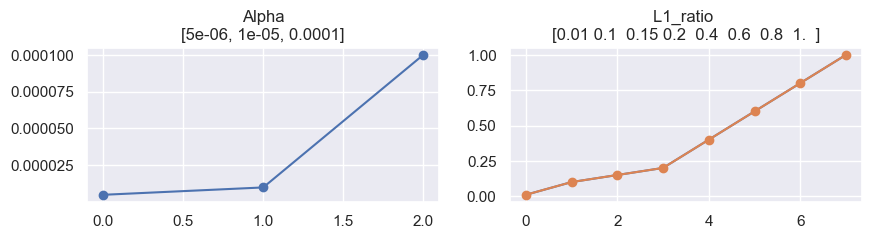

In [19]:
alphas = np.array([5e-6, 1e-5, 1e-4])
l1_ratios = np.concatenate(([0.01, 0.1, 0.15], np.linspace(0.2, 1, 5)))
plt.subplots(1,2, figsize=(10,2))
plt.subplot(121)
plt.plot(alphas, marker='o')
plt.title(f"Alpha\n{alphas.tolist()}")
plt.subplot(122)
plt.plot(l1_ratios)
plt.plot(l1_ratios, marker='o')
plt.title(f"L1_ratio \n{l1_ratios}");

In [20]:
en_hps = list(it.product(alphas, l1_ratios))
en_hp_settings = [
    dict(alpha=alpha, l1_ratio=l1_ratio)
    for alpha, l1_ratio in en_hps
]
num_hp = len(en_hp_settings)
log.info(f"Elastic net hyperparam settings:\n{pformat(en_hp_settings)}")

[2023-04-28 08:49:14]  Elastic net hyperparam settings:
[{'alpha': 5e-06, 'l1_ratio': 0.01},
 {'alpha': 5e-06, 'l1_ratio': 0.1},
 {'alpha': 5e-06, 'l1_ratio': 0.15},
 {'alpha': 5e-06, 'l1_ratio': 0.2},
 {'alpha': 5e-06, 'l1_ratio': 0.4},
 {'alpha': 5e-06, 'l1_ratio': 0.6000000000000001},
 {'alpha': 5e-06, 'l1_ratio': 0.8},
 {'alpha': 5e-06, 'l1_ratio': 1.0},
 {'alpha': 1e-05, 'l1_ratio': 0.01},
 {'alpha': 1e-05, 'l1_ratio': 0.1},
 {'alpha': 1e-05, 'l1_ratio': 0.15},
 {'alpha': 1e-05, 'l1_ratio': 0.2},
 {'alpha': 1e-05, 'l1_ratio': 0.4},
 {'alpha': 1e-05, 'l1_ratio': 0.6000000000000001},
 {'alpha': 1e-05, 'l1_ratio': 0.8},
 {'alpha': 1e-05, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 0.01},
 {'alpha': 0.0001, 'l1_ratio': 0.1},
 {'alpha': 0.0001, 'l1_ratio': 0.15},
 {'alpha': 0.0001, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 0.4},
 {'alpha': 0.0001, 'l1_ratio': 0.6000000000000001},
 {'alpha': 0.0001, 'l1_ratio': 0.8},
 {'alpha': 0.0001, 'l1_ratio': 1.0}]


In [21]:
def xval(
    cv_valpreds,
    untrained_mdl,
    model_nm_prefix="",
    pcols_like_list=None,
    overwrite_models=False,
    verbose=1,
):
    """Cross validates the ensemble model.
    
    :param pcols_like_list: A list of partial predcol names to select
        a subset of predcols. Example: `['pred_target_sam_v4_20']` will
        select `pred_target_sam_v4_20_cv0`, `pred_target_sam_v4_20_cv1`
        and `pred_target_sam_v4_20_cv2`.
    """
    cv = len(cv_valpreds["cv_predcols_map"])
    ensmbl_cv_models, ensmbl_cv_predcols, ensmbl_cv_metrics = [], [], []
    cv_pred_descs, cv_num_feats, cv_coef_dfs = [], [], []
    verbose_pos = verbose > 0

    raw_iterand = zip(
        range(cv),
        cv_valpreds["cv_predcols_map"],
        cv_valpreds["cv_to_val_test_map"],
    )
    if verbose_pos:
        iterand = tqdm(raw_iterand, desc="CV split", total=cv)
    else:
        iterand = raw_iterand
    for split, predcols, val_test_map in iterand:
        model_nm = f"{model_nm_prefix}_cv{split}.pkl"
        train_df, test_df = val_test_map["val"], val_test_map["test"]
        if pcols_like_list is None:
            chosen_cols = predcols
        else:
            chosen_cols = extract_cols_like(all_cols=predcols, match_cols=pcols_like_list)
        # Try to load the trained model
        loaded_mdl = ut.load_model(model_nm, model_folder=MODEL_DIR)
        train_st_tm = time.time()
        if loaded_mdl and not overwrite_models:
            if verbose_pos:
                log.info(f"Loaded saved model: `{model_nm}`")
            split_mdl = loaded_mdl
        else:
            if verbose_pos:
                log.info(f"Training new model. No model named `{model_nm}` saved...")
            split_mdl = sklearn.base.clone(untrained_mdl)
            # Use train and test df which have prediction columns from models trained on
            # each target, cval split
            if verbose_pos:
                log.info(
                    f"{split=}, {train_df[chosen_cols].shape=}, {train_df.era.min()=}, "
                    f"{train_df.era.max()=}, {train_df.era.nunique()=}",
                )
            # We don't have to filter out NAs as cyrus doesn't have NA values.
            if verbose_pos:
                log.info(f"Training model on {len(chosen_cols)} columns: {chosen_cols}")
            split_mdl.fit(X=train_df[chosen_cols], y=train_df[TARGET_COL])
            if verbose_pos:
                log.info(f"Saving the trained model `{model_nm}`...")
            ut.save_model(model=split_mdl, name=model_nm, model_folder=MODEL_DIR)
        # Model coefficients
        cv_coef_dfs.append(
            pd.DataFrame(
                {f"coef_cv{split}": np.concatenate(([split_mdl.intercept_], split_mdl.coef_))},
                index=["intercept"] + [refmt_predcols(c) for c in chosen_cols],
            )
        )
        ensmbl_predcol = f"ensemble_{model_nm_prefix}__cv{split}"
        if verbose_pos:
            log.info(f"Predicting column: {ensmbl_predcol}")
        test_df[ensmbl_predcol] = split_mdl.predict(X=test_df[chosen_cols])
        metrics_df = ut.validation_metrics(
            validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
        )
        # Get stats on number of zeroed out features
        z_coef = split_mdl.coef_==0
        cv_num_feats.append((~z_coef).sum())
        if verbose_pos:
            log.info(f"Percent of zero columns: {z_coef.mean():.0%} ({z_coef.sum()}/{len(z_coef)})")
            log.info(f"Training time: {(time.time() - train_st_tm):.0f} seconds\n")
        # collect data for saving
        ensmbl_cv_models.append(split_mdl)
        ensmbl_cv_predcols.append(ensmbl_predcol)
        ensmbl_cv_metrics.append(metrics_df)
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    if verbose_pos:
        log.info("Prediction distribution")
        display(pd.concat(cv_pred_descs, axis=1))
    cv_metrics = ut.to_cv_agg_df(ensmbl_cv_metrics)
    if verbose == -1:
        display(pd.concat(cv_coef_dfs, axis=1).transpose().style.bar(align="zero", color=["#d65f5f", "#74A662"]))
        display(cv_metrics.loc[["cv_mean"]])
    return {
        "cv_models": ensmbl_cv_models,
        "cv_pred_cols": ensmbl_cv_predcols,
        "cv_metrics": cv_metrics,
        "num_feats": int(np.mean(cv_num_feats)),
    }

In [ ]:
cv = len(cv_valpreds["cv_predcols_map"])
# mapping like so
# [
#    {"hp": {"alpha": 0.1, "l1_ratio": 1.}, "cv_models": [m0, m1, m2],
#     "cv_metrics": [m0df, m1df, m2df]}, "cv_cols": ["ensemble_alpha_0.1_l1_ratio_1._cv0", ...]
# ]
hp_cv_models = []
for i, hp_dict in tqdm(enumerate(en_hp_settings), total=len(en_hp_settings), desc="Hyperparam setting"):
    log.info(f"\nHyperparam settings {i+1}/{num_hp}: {hp_dict}")
    hp_title = "".join(f"_{hp_nm}_{hp_val}" for hp_nm, hp_val in hp_dict.items())
    hp_cv_models.append(
        {
            "hp": hp_dict,
            **xval(
                cv_valpreds=cv_valpreds,
                untrained_mdl=sklin.ElasticNet(random_state=42, fit_intercept=True, max_iter=3000, **hp_dict),
                model_nm_prefix=f"en_{hp_title}",
            )
        }
    )

In [ ]:
ut.pickle_obj(fl="ckpt_hp_cv_models.pkl", obj=hp_cv_models)

### 3.3 Plot comparisons of various hyperparams

In [22]:
def heatmap_metrics(
    metric_mat: np.ndarray,
    xlabels,
    ylabels,
    metric_nm,
    xtitle,
    ytitle,
    figsize=(5, 4),
    fmt=".3f",
    ax=None,
    **hm_kwargs,
):
    """Using seaborn library plots a heatmap of the metric_mat 
    where the xlabels and ylabels are the corresponding label names.
    """
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        metric_mat,
        annot=True,
        fmt=fmt,
        xticklabels=xlabels,
        yticklabels=np.round(ylabels,10),
        ax=ax,
        cmap="Blues",
        **hm_kwargs,
    )
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(metric_nm)

In [23]:
def build_hp_metrics_mat(hp_cv_models, metric_or_field, hp1: str, hp2: str):
    """Creates a 2d matrix extracting out the metrics"""
    # swap hp1 and hp2 because x-axis is cols and y-axis is rows
    hp2, hp1 = hp1, hp2
    hps = hp1, hp2
    uniq_vals = {
        hp: np.sort(np.unique([hpcv["hp"][hp] for hpcv in hp_cv_models]))
        for hp in hps
    }
    # A matrix of the metrics
    mat = np.empty((len(uniq_vals[hp1]), len(uniq_vals[hp2])))
    mat[:] = np.nan
    # Build a mapping of hyperpam val to ix in the matrix
    hp_ix_map = {
        hp:{hp_val: ix for ix, hp_val in enumerate(uniq_vals[hp])}
        for hp in hps
    }
    for hpcv in hp_cv_models:
        hp1_val, hp2_val = hpcv["hp"][hp1], hpcv["hp"][hp2]
        hp1_ix = hp_ix_map[hp1][hp1_val]
        hp2_ix = hp_ix_map[hp2][hp2_val]
        try:
            mat[hp1_ix, hp2_ix] = hpcv[metric_or_field]
        except KeyError:
            mat[hp1_ix, hp2_ix] = hpcv["cv_metrics"].loc["cv_mean", metric_or_field]
    return mat

### 4.2 Elastic net visualise hyperparm performance

#### *It does look we can beat the baseline of simply averaging the predictions of top-8 target cols*

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, metric_or_field, fmt in zip(
    axes.flat,
    ["mean", "sharpe", "num_feats"],
    [".2%", ".3f", ".0f"]
):
    heatmap_metrics(
        metric_mat=build_hp_metrics_mat(
            hp_cv_models=hp_cv_models,
            metric_or_field=metric_or_field,
            hp1="alpha",
            hp2="l1_ratio",
        ),
        xlabels=alphas,
        ylabels=l1_ratios,
        metric_nm=metric_or_field,
        xtitle="alpha",
        ytitle="l1_ratio",
        ax=ax,
        fmt=fmt,
    )
plt.tight_layout()

In [ ]:
ut.fmt_metrics_df(bl_top8pred_mean_metrics)

In [ ]:
best_hp = {"alpha": 1e-4, "l1_ratio": 0.2}
best_ix = [ix for ix, cv_res in enumerate(hp_cv_models) if cv_res["hp"]==best_hp][0]
log.info(f"Best hp setting for elastic net: {best_hp}")
display(hp_cv_models[best_ix]["cv_metrics"].loc[["cv_mean"]])
best_hp_models = hp_cv_models[best_ix]["cv_models"]

In [ ]:
fmtd_pred_cols = np.array([
    refmt_predcols(col)
    # all 3 cv have the same prefix of column names
    for col in cv_valpreds["cv_predcols_map"][0]
])
fmtd_pred_cols

In [24]:
def plot_ft_imp(cv_models, fmtd_pred_cols):
    cv_nz_fts = []
    all_cv_nz_fts = None
    for mdl in cv_models:
        nz_cols = fmtd_pred_cols[mdl.coef_!=0]
        if all_cv_nz_fts is None:
            all_cv_nz_fts = set(nz_cols)
        else:
            all_cv_nz_fts &= set(nz_cols)
        cv_nz_fts.append(nz_cols)
    ft_wts = np.concatenate(
        [mdl.coef_[:, None] for mdl in cv_models],
        axis=1,
    )
    mean_ft_wts = ft_wts.mean(axis=1)
    std_ft_wts = ft_wts.std(axis=1)
    fig, ax = plt.subplots(figsize=(10,8))
    std_ix = mean_ft_wts.argsort()[::-1]
    ax.barh(
        y=fmtd_pred_cols[std_ix],
        width=mean_ft_wts[std_ix],
        xerr=std_ft_wts[std_ix],
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10,
    )
    for i, v in enumerate(mean_ft_wts[std_ix]):
        xpos = -0.015 if v == 0 else np.sign(v) * -0.015
        ax.text(xpos, i - .25, str(round(v, 3)))
    ax.set_xlabel('Weights')
    ax.set_title(
        'Model Weights with Stddev Error Bars\n'
        + f"Cols nonzero in all cv: {sorted(all_cv_nz_fts)}"
    )
    log.info(
        "\n"
        + "\n".join(
            f"Nonzero features in cv={i} |\n{sorted(nz_ft)}"
            for i, nz_ft in enumerate(cv_nz_fts)
        )
    )
    ax.axvline(color="red")
    plt.xticks(rotation=45);
    return ax

In [ ]:
plot_ft_imp(cv_models=best_hp_models, fmtd_pred_cols=fmtd_pred_cols);

## 5.1 Selection with pairwise models

In [25]:
PREDCOL_PREFIXES = [c[:-4] for c in cv_valpreds["cv_predcols_map"][0]]
PREDCOL_PREFIXES[:3]

['pred_target_arthur_v4_20',
 'pred_target_arthur_v4_60',
 'pred_target_thomas_v4_20']

In [26]:
ridge_alphas = [0.1, 1.0, 10]

In [29]:
int_pair_models_map = {
    # intercept
    True: [],
    # no intercept
    False: []
}
for intercept, pair_models in tqdm(int_pair_models_map.items(), desc="Intercept"):
    for paircol in tqdm(PREDCOL_PREFIXES, desc="Prediction columns"):
        if paircol == "pred_target_cyrus_v4_20":
            continue
        verbose_flag = -1
        log.info(f"\nIntercept: {intercept} ; Pair-col: {paircol} ")
        for alpha in ridge_alphas:
            if intercept is True:
                model_nm_pfx = f"pair_{paircol}_ridge_alpha_{alpha}"
            else:
                model_nm_pfx = f"pair_{paircol}_ridge_alpha_{alpha}_noint"
            pair_models.append(
                {
                    "hp": {"paircol": paircol, "alpha": alpha},
                    **xval(
                        cv_valpreds=cv_valpreds,
                        untrained_mdl=sklearn.base.clone(sklin.Ridge(alpha=alpha, fit_intercept=intercept, random_state=42)),
                        model_nm_prefix=model_nm_pfx,
                        pcols_like_list=["pred_target_cyrus_v4_20", paircol],
                        overwrite_models=False,
                        verbose=verbose_flag,
                    )
                }
            )
            verbose_flag = 0

Intercept:   0%|          | 0/2 [00:00<?, ?it/s]

Prediction columns:   0%|          | 0/36 [00:00<?, ?it/s]

[2023-04-28 08:51:12]  
Intercept: True ; Pair-col: pred_target_arthur_v4_20 


,intercept,arthur_v4_20,cyrus_v4_20
coef_cv0,0.229440,0.268676,0.272558
coef_cv1,0.255147,0.011563,0.477543
coef_cv2,0.396064,-0.127829,0.335927


,mean,std,sharpe
cv_mean,0.027494,0.01894,1.464541


[2023-04-28 08:51:15]  
Intercept: True ; Pair-col: pred_target_arthur_v4_60 


,intercept,arthur_v4_60,cyrus_v4_20
coef_cv0,0.274100,0.139661,0.312092
coef_cv1,0.264566,-0.024453,0.494786
coef_cv2,0.389239,-0.127195,0.349029


,mean,std,sharpe
cv_mean,0.02769,0.018908,1.482365


[2023-04-28 08:51:18]  
Intercept: True ; Pair-col: pred_target_thomas_v4_20 


,intercept,thomas_v4_20,cyrus_v4_20
coef_cv0,0.309053,-0.005175,0.387225
coef_cv1,0.230839,0.193940,0.343839
coef_cv2,0.337880,0.136633,0.187584


,mean,std,sharpe
cv_mean,0.027824,0.019219,1.466478


[2023-04-28 08:51:21]  
Intercept: True ; Pair-col: pred_target_thomas_v4_60 


,intercept,thomas_v4_60,cyrus_v4_20
coef_cv0,0.308467,0.022052,0.361170
coef_cv1,0.252998,0.081229,0.412253
coef_cv2,0.358297,0.028702,0.254663


,mean,std,sharpe
cv_mean,0.028145,0.019354,1.476367


[2023-04-28 08:51:24]  
Intercept: True ; Pair-col: pred_target_cyrus_v4_60 


,intercept,cyrus_v4_20,cyrus_v4_60
coef_cv0,0.315438,0.249145,0.120107
coef_cv1,0.258829,0.475726,0.006024
coef_cv2,0.360533,0.295112,-0.016183


,mean,std,sharpe
cv_mean,0.028222,0.019088,1.506157


[2023-04-28 08:51:26]  
Intercept: True ; Pair-col: pred_target_caroline_v4_20 


,intercept,cyrus_v4_20,caroline_v4_20
coef_cv0,0.298736,0.079838,0.322968
coef_cv1,0.249578,0.204127,0.296212
coef_cv2,0.358981,0.231184,0.050845


,mean,std,sharpe
cv_mean,0.027778,0.018404,1.526316


[2023-04-28 08:51:29]  
Intercept: True ; Pair-col: pred_target_caroline_v4_60 


,intercept,cyrus_v4_20,caroline_v4_60
coef_cv0,0.317686,0.213990,0.150730
coef_cv1,0.259184,0.468157,0.012881
coef_cv2,0.360194,0.308209,-0.028611


,mean,std,sharpe
cv_mean,0.028118,0.018877,1.512159


[2023-04-28 08:51:32]  
Intercept: True ; Pair-col: pred_target_sam_v4_20 


,intercept,cyrus_v4_20,sam_v4_20
coef_cv0,0.300900,0.165589,0.232810
coef_cv1,0.248501,0.224577,0.277873
coef_cv2,0.360995,0.272899,0.005097


,mean,std,sharpe
cv_mean,0.027856,0.018616,1.517083


[2023-04-28 08:51:35]  
Intercept: True ; Pair-col: pred_target_sam_v4_60 


,intercept,cyrus_v4_20,sam_v4_60
coef_cv0,0.316178,0.233528,0.134208
coef_cv1,0.260261,0.438332,0.040556
coef_cv2,0.361044,0.283624,-0.005726


,mean,std,sharpe
cv_mean,0.028183,0.018791,1.519634


[2023-04-28 08:51:38]  
Intercept: True ; Pair-col: pred_target_xerxes_v4_20 


,intercept,cyrus_v4_20,xerxes_v4_20
coef_cv0,0.307231,0.343993,0.041713
coef_cv1,0.248485,0.221254,0.281197
coef_cv2,0.358071,0.196573,0.087309


,mean,std,sharpe
cv_mean,0.027784,0.0189,1.494057


[2023-04-28 08:51:41]  
Intercept: True ; Pair-col: pred_target_xerxes_v4_60 


,intercept,cyrus_v4_20,xerxes_v4_60
coef_cv0,0.313951,0.270550,0.101707
coef_cv1,0.259681,0.454595,0.025453
coef_cv2,0.360569,0.295515,-0.016662


,mean,std,sharpe
cv_mean,0.028176,0.018992,1.508384


[2023-04-28 08:51:44]  
Intercept: True ; Pair-col: pred_target_nomi_v4_20 


,intercept,cyrus_v4_20,nomi_v4_20
coef_cv0,0.308450,0.344745,0.038495
coef_cv1,0.257119,0.368651,0.116471
coef_cv2,0.357148,0.206953,0.078646


,mean,std,sharpe
cv_mean,0.028113,0.018966,1.506095


[2023-04-28 08:51:48]  
Intercept: True ; Pair-col: pred_target_nomi_v4_60 


,intercept,cyrus_v4_20,nomi_v4_60
coef_cv0,0.317123,0.286569,0.079271
coef_cv1,0.260866,0.452126,0.025555
coef_cv2,0.359832,0.302614,-0.022289


,mean,std,sharpe
cv_mean,0.028324,0.019094,1.508085


[2023-04-28 08:51:52]  
Intercept: True ; Pair-col: pred_target_tyler_v4_20 


,intercept,cyrus_v4_20,tyler_v4_20
coef_cv0,0.302426,0.322231,0.073065
coef_cv1,0.249825,0.402774,0.097012
coef_cv2,0.343158,0.163737,0.149693


,mean,std,sharpe
cv_mean,0.027904,0.01867,1.524934


[2023-04-28 08:51:56]  
Intercept: True ; Pair-col: pred_target_tyler_v4_60 


,intercept,cyrus_v4_20,tyler_v4_60
coef_cv0,0.311180,0.251678,0.126007
coef_cv1,0.258760,0.458453,0.023442
coef_cv2,0.360581,0.255456,0.023378


,mean,std,sharpe
cv_mean,0.028492,0.019348,1.50283


[2023-04-28 08:51:59]  
Intercept: True ; Pair-col: pred_target_victor_v4_20 


,intercept,cyrus_v4_20,victor_v4_20
coef_cv0,0.289772,0.160777,0.259732
coef_cv1,0.256888,0.461203,0.024425
coef_cv2,0.356025,0.222678,0.065224


,mean,std,sharpe
cv_mean,0.027779,0.0189,1.49374


[2023-04-28 08:52:03]  
Intercept: True ; Pair-col: pred_target_victor_v4_60 


,intercept,cyrus_v4_20,victor_v4_60
coef_cv0,0.314837,0.243927,0.126462
coef_cv1,0.258859,0.474406,0.007285
coef_cv2,0.360640,0.296330,-0.017617


,mean,std,sharpe
cv_mean,0.028068,0.018872,1.508541


[2023-04-28 08:52:07]  
Intercept: True ; Pair-col: pred_target_ralph_v4_20 


,intercept,cyrus_v4_20,ralph_v4_20
coef_cv0,0.308758,0.423430,-0.040785
coef_cv1,0.256277,0.309811,0.176988
coef_cv2,0.356878,0.150592,0.135596


,mean,std,sharpe
cv_mean,0.027918,0.018904,1.499338


[2023-04-28 08:52:12]  
Intercept: True ; Pair-col: pred_target_ralph_v4_60 


,intercept,cyrus_v4_20,ralph_v4_60
coef_cv0,0.314814,0.305010,0.065510
coef_cv1,0.260100,0.459152,0.020066
coef_cv2,0.361253,0.277181,0.000303


,mean,std,sharpe
cv_mean,0.02809,0.019066,1.498549


[2023-04-28 08:52:17]  
Intercept: True ; Pair-col: pred_target_waldo_v4_20 


,intercept,cyrus_v4_20,waldo_v4_20
coef_cv0,0.305862,0.292816,0.095599
coef_cv1,0.254208,0.361120,0.129886
coef_cv2,0.347785,0.109166,0.195155


,mean,std,sharpe
cv_mean,0.028436,0.018915,1.532382


[2023-04-28 08:52:21]  
Intercept: True ; Pair-col: pred_target_waldo_v4_60 


,intercept,cyrus_v4_20,waldo_v4_60
coef_cv0,0.316728,0.263165,0.103501
coef_cv1,0.259186,0.469616,0.011425
coef_cv2,0.361604,0.263926,0.012839


,mean,std,sharpe
cv_mean,0.028557,0.019211,1.513593


[2023-04-28 08:52:26]  
Intercept: True ; Pair-col: pred_target_jerome_v4_20 


,intercept,cyrus_v4_20,jerome_v4_20
coef_cv0,0.304922,0.306227,0.084222
coef_cv1,0.256194,0.437737,0.049236
coef_cv2,0.354587,0.220452,0.070296


,mean,std,sharpe
cv_mean,0.028028,0.018751,1.520951


[2023-04-28 08:52:31]  
Intercept: True ; Pair-col: pred_target_jerome_v4_60 


,intercept,cyrus_v4_20,jerome_v4_60
coef_cv0,0.312373,0.308641,0.066916
coef_cv1,0.258204,0.489798,-0.006785
coef_cv2,0.361306,0.273752,0.003624


,mean,std,sharpe
cv_mean,0.028256,0.019083,1.505863


[2023-04-28 08:52:36]  
Intercept: True ; Pair-col: pred_target_janet_v4_20 


,intercept,cyrus_v4_20,janet_v4_20
coef_cv0,0.270031,0.298514,0.161684
coef_cv1,0.243464,0.447941,0.064553
coef_cv2,0.369868,0.300801,-0.040533


,mean,std,sharpe
cv_mean,0.02782,0.018759,1.500209


[2023-04-28 08:52:41]  
Intercept: True ; Pair-col: pred_target_janet_v4_60 


,intercept,cyrus_v4_20,janet_v4_60
coef_cv0,0.275609,0.263218,0.185879
coef_cv1,0.264711,0.508880,-0.038894
coef_cv2,0.369882,0.323409,-0.063197


,mean,std,sharpe
cv_mean,0.027414,0.018664,1.493368


[2023-04-28 08:52:46]  
Intercept: True ; Pair-col: pred_target_ben_v4_20 


,intercept,cyrus_v4_20,ben_v4_20
coef_cv0,0.309203,0.400814,-0.019069
coef_cv1,0.248102,0.369241,0.133947
coef_cv2,0.345344,0.178208,0.130986


,mean,std,sharpe
cv_mean,0.02818,0.018802,1.522222


[2023-04-28 08:52:51]  
Intercept: True ; Pair-col: pred_target_ben_v4_60 


,intercept,cyrus_v4_20,ben_v4_60
coef_cv0,0.311571,0.338881,0.038129
coef_cv1,0.259479,0.419865,0.060582
coef_cv2,0.360397,0.249723,0.029494


,mean,std,sharpe
cv_mean,0.028258,0.019125,1.503246


[2023-04-28 08:52:57]  
Intercept: True ; Pair-col: pred_target_alan_v4_20 


,intercept,cyrus_v4_20,alan_v4_20
coef_cv0,0.238531,0.251719,0.271527
coef_cv1,0.239552,0.446012,0.074314
coef_cv2,0.360726,0.276285,0.002251


,mean,std,sharpe
cv_mean,0.027542,0.018854,1.48649


[2023-04-28 08:53:03]  
Intercept: True ; Pair-col: pred_target_alan_v4_60 


,intercept,cyrus_v4_20,alan_v4_60
coef_cv0,0.273606,0.269884,0.183098
coef_cv1,0.254521,0.469551,0.020818
coef_cv2,0.371151,0.316423,-0.058673


,mean,std,sharpe
cv_mean,0.027824,0.018735,1.501959


[2023-04-28 08:53:08]  
Intercept: True ; Pair-col: pred_target_paul_v4_20 


,intercept,cyrus_v4_20,paul_v4_20
coef_cv0,0.308264,0.381410,0.002223
coef_cv1,0.255673,0.460452,0.027590
coef_cv2,0.359814,0.266438,0.013908


,mean,std,sharpe
cv_mean,0.027613,0.01894,1.481887


[2023-04-28 08:53:14]  
Intercept: True ; Pair-col: pred_target_paul_v4_60 


,intercept,cyrus_v4_20,paul_v4_60
coef_cv0,0.308326,0.379710,0.003801
coef_cv1,0.258012,0.468186,0.015188
coef_cv2,0.361229,0.276796,0.000735


,mean,std,sharpe
cv_mean,0.027686,0.018956,1.485004


[2023-04-28 08:53:20]  
Intercept: True ; Pair-col: pred_target_george_v4_20 


,intercept,cyrus_v4_20,george_v4_20
coef_cv0,0.308330,0.382051,0.001451
coef_cv1,0.246908,0.437900,0.067585
coef_cv2,0.357591,0.266425,0.018277


,mean,std,sharpe
cv_mean,0.027771,0.019157,1.471248


[2023-04-28 08:53:26]  
Intercept: True ; Pair-col: pred_target_george_v4_60 


,intercept,cyrus_v4_20,george_v4_60
coef_cv0,0.308180,0.378996,0.004803
coef_cv1,0.254594,0.455818,0.034373
coef_cv2,0.360802,0.275130,0.003239


,mean,std,sharpe
cv_mean,0.027791,0.019055,1.482868


[2023-04-28 08:53:30]  
Intercept: True ; Pair-col: pred_target_william_v4_20 


,intercept,cyrus_v4_20,william_v4_20
coef_cv0,0.305568,0.342010,0.046726
coef_cv1,0.251009,0.397510,0.099019
coef_cv2,0.355243,0.231777,0.057097


,mean,std,sharpe
cv_mean,0.02768,0.018919,1.482189


[2023-04-28 08:53:35]  
Intercept: True ; Pair-col: pred_target_william_v4_60 


,intercept,cyrus_v4_20,william_v4_60
coef_cv0,0.309661,0.335044,0.045463
coef_cv1,0.258701,0.466764,0.015088
coef_cv2,0.361272,0.279806,-0.002334


,mean,std,sharpe
cv_mean,0.028025,0.018937,1.502938


Prediction columns:   0%|          | 0/36 [00:00<?, ?it/s]

[2023-04-28 08:53:40]  
Intercept: False ; Pair-col: pred_target_arthur_v4_20 


,intercept,arthur_v4_20,cyrus_v4_20
coef_cv0,0.000000,0.730342,0.269610
coef_cv1,0.000000,0.529659,0.468787
coef_cv2,0.000000,0.645187,0.352558


,mean,std,sharpe
cv_mean,0.024872,0.017585,1.4309


[2023-04-28 08:53:46]  
Intercept: False ; Pair-col: pred_target_arthur_v4_60 


,intercept,arthur_v4_60,cyrus_v4_20
coef_cv0,0.000000,0.494227,0.505028
coef_cv1,0.000000,0.321915,0.675833
coef_cv2,0.000000,0.324143,0.673374


,mean,std,sharpe
cv_mean,0.026585,0.018642,1.437431


[2023-04-28 08:53:52]  
Intercept: False ; Pair-col: pred_target_thomas_v4_20 


,intercept,thomas_v4_20,cyrus_v4_20
coef_cv0,0.000000,0.271531,0.728330
coef_cv1,0.000000,0.440963,0.557548
coef_cv2,0.000000,0.578095,0.420346


,mean,std,sharpe
cv_mean,0.027809,0.019425,1.449963


[2023-04-28 08:53:59]  
Intercept: False ; Pair-col: pred_target_thomas_v4_60 


,intercept,thomas_v4_60,cyrus_v4_20
coef_cv0,0.000000,0.025819,0.974041
coef_cv1,0.000000,0.141510,0.856736
coef_cv2,0.000000,0.166868,0.830986


,mean,std,sharpe
cv_mean,0.028103,0.019373,1.468172


[2023-04-28 08:54:08]  
Intercept: False ; Pair-col: pred_target_cyrus_v4_60 


,intercept,cyrus_v4_20,cyrus_v4_60
coef_cv0,0.000000,0.985700,0.014155
coef_cv1,0.000000,1.061026,-0.062922
coef_cv2,0.000000,1.090985,-0.092994


,mean,std,sharpe
cv_mean,0.027549,0.01886,1.486692


[2023-04-28 08:54:17]  
Intercept: False ; Pair-col: pred_target_caroline_v4_20 


,intercept,cyrus_v4_20,caroline_v4_20
coef_cv0,0.000000,0.406594,0.593507
coef_cv1,0.000000,0.488572,0.509732
coef_cv2,0.000000,0.571530,0.426517


,mean,std,sharpe
cv_mean,0.027874,0.018517,1.524126


[2023-04-28 08:54:26]  
Intercept: False ; Pair-col: pred_target_caroline_v4_60 


,intercept,cyrus_v4_20,caroline_v4_60
coef_cv0,0.000000,0.956654,0.043185
coef_cv1,0.000000,1.054593,-0.056489
coef_cv2,0.000000,1.090155,-0.092209


,mean,std,sharpe
cv_mean,0.027559,0.018874,1.484674


[2023-04-28 08:54:35]  
Intercept: False ; Pair-col: pred_target_sam_v4_20 


,intercept,cyrus_v4_20,sam_v4_20
coef_cv0,0.000000,0.493639,0.506327
coef_cv1,0.000000,0.483382,0.514870
coef_cv2,0.000000,0.623712,0.374188


,mean,std,sharpe
cv_mean,0.027948,0.018663,1.518755


[2023-04-28 08:54:43]  
Intercept: False ; Pair-col: pred_target_sam_v4_60 


,intercept,cyrus_v4_20,sam_v4_60
coef_cv0,0.000000,0.969034,0.030809
coef_cv1,0.000000,1.018043,-0.019961
coef_cv2,0.000000,1.063119,-0.065224


,mean,std,sharpe
cv_mean,0.027628,0.018872,1.488236


[2023-04-28 08:54:51]  
Intercept: False ; Pair-col: pred_target_xerxes_v4_20 


,intercept,cyrus_v4_20,xerxes_v4_20
coef_cv0,0.000000,0.625776,0.374201
coef_cv1,0.000000,0.413219,0.584990
coef_cv2,0.000000,0.548543,0.449660


,mean,std,sharpe
cv_mean,0.027809,0.018891,1.496464


[2023-04-28 08:54:58]  
Intercept: False ; Pair-col: pred_target_xerxes_v4_60 


,intercept,cyrus_v4_20,xerxes_v4_60
coef_cv0,0.000000,0.997446,0.002413
coef_cv1,0.000000,1.037906,-0.039818
coef_cv2,0.000000,1.084999,-0.087037


,mean,std,sharpe
cv_mean,0.027513,0.018861,1.48388


[2023-04-28 08:55:06]  
Intercept: False ; Pair-col: pred_target_nomi_v4_20 


,intercept,cyrus_v4_20,nomi_v4_20
coef_cv0,0.000000,0.952092,0.047748
coef_cv1,0.000000,0.842930,0.155092
coef_cv2,0.000000,0.695869,0.301797


,mean,std,sharpe
cv_mean,0.027983,0.018963,1.498998


[2023-04-28 08:55:14]  
Intercept: False ; Pair-col: pred_target_nomi_v4_60 


,intercept,cyrus_v4_20,nomi_v4_60
coef_cv0,0.000000,1.052764,-0.052852
coef_cv1,0.000000,1.062339,-0.064236
coef_cv2,0.000000,1.103544,-0.105579


,mean,std,sharpe
cv_mean,0.027196,0.018858,1.465462


[2023-04-28 08:55:22]  
Intercept: False ; Pair-col: pred_target_tyler_v4_20 


,intercept,cyrus_v4_20,tyler_v4_20
coef_cv0,0.000000,0.664678,0.335169
coef_cv1,0.000000,0.679002,0.319315
coef_cv2,0.000000,0.475259,0.522182


,mean,std,sharpe
cv_mean,0.027932,0.018608,1.532789


[2023-04-28 08:55:37]  
Intercept: False ; Pair-col: pred_target_tyler_v4_60 


,intercept,cyrus_v4_20,tyler_v4_60
coef_cv0,0.000000,0.904311,0.095462
coef_cv1,0.000000,0.985369,0.012712
coef_cv2,0.000000,0.930944,0.067021


,mean,std,sharpe
cv_mean,0.027969,0.01906,1.493247


[2023-04-28 08:55:55]  
Intercept: False ; Pair-col: pred_target_victor_v4_20 


,intercept,cyrus_v4_20,victor_v4_20
coef_cv0,0.000000,0.488144,0.511548
coef_cv1,0.000000,0.768601,0.229499
coef_cv2,0.000000,0.609228,0.388662


,mean,std,sharpe
cv_mean,0.027662,0.018784,1.494965


[2023-04-28 08:56:04]  
Intercept: False ; Pair-col: pred_target_victor_v4_60 


,intercept,cyrus_v4_20,victor_v4_60
coef_cv0,0.000000,0.938559,0.061253
coef_cv1,0.000000,1.035704,-0.037616
coef_cv2,0.000000,1.063547,-0.065585


,mean,std,sharpe
cv_mean,0.027792,0.018993,1.486791


[2023-04-28 08:56:12]  
Intercept: False ; Pair-col: pred_target_ralph_v4_20 


,intercept,cyrus_v4_20,ralph_v4_20
coef_cv0,0.000000,1.010371,-0.010510
coef_cv1,0.000000,0.762263,0.235757
coef_cv2,0.000000,0.654555,0.343326


,mean,std,sharpe
cv_mean,0.027983,0.018948,1.500236


[2023-04-28 08:56:20]  
Intercept: False ; Pair-col: pred_target_ralph_v4_60 


,intercept,cyrus_v4_20,ralph_v4_60
coef_cv0,0.000000,1.072973,-0.073097
coef_cv1,0.000000,1.074172,-0.076096
coef_cv2,0.000000,1.090986,-0.093001


,mean,std,sharpe
cv_mean,0.027202,0.018783,1.47296


[2023-04-28 08:56:45]  
Intercept: False ; Pair-col: pred_target_waldo_v4_20 


,intercept,cyrus_v4_20,waldo_v4_20
coef_cv0,0.000000,0.785880,0.213944
coef_cv1,0.000000,0.756597,0.241545
coef_cv2,0.000000,0.498620,0.499260


,mean,std,sharpe
cv_mean,0.028433,0.01893,1.530579


[2023-04-28 08:56:54]  
Intercept: False ; Pair-col: pred_target_waldo_v4_60 


,intercept,cyrus_v4_20,waldo_v4_60
coef_cv0,0.000000,1.007498,-0.007635
coef_cv1,0.000000,1.054180,-0.056103
coef_cv2,0.000000,1.030307,-0.032327


,mean,std,sharpe
cv_mean,0.027509,0.01894,1.475813


KeyboardInterrupt: 

In [ ]:
ut.pickle_obj(fl="./ckpt_pair_models.pkl", obj=pair_models)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))
for ax, metric_or_field, fmt in zip(
    axes.flat,
    ["mean", "sharpe"],
    [".1%", ".2f"]
):
    heatmap_metrics(
        metric_mat=build_hp_metrics_mat(
            hp_cv_models=pair_models,
            metric_or_field=metric_or_field,
            hp1="paircol",
            hp2="alpha",
        ),
        xlabels=PREDCOL_PREFIXES,
        ylabels=ridge_alphas,
        metric_nm=metric_or_field,
        xtitle="paircol",
        ytitle="alpha",
        ax=ax,
        fmt=fmt,
        annot_kws={"fontsize":7 },
    )
plt.tight_layout()

In [ ]:
pair_models[118]

## 5.2 Selection with stepwise regression

## 6. Plot prediction correlations

In [ ]:
avg_corr = None
for pred_cols, cv_vp in zip(
    cv_valpreds["cv_predcols_map"],
    cv_valpreds["cv_to_val_test_map"]
):
    cv_vp_clone_df = copy.deepcopy(cv_vp['val'][pred_cols]).rename(
        columns={c: refmt_predcols(c) for c in pred_cols},
    )
    if avg_corr is None:
        avg_corr = cv_vp_clone_df.corr()
    else:
        avg_corr += cv_vp_clone_df.corr()
avg_corr /= cv

In [ ]:
fig = px.imshow(np.round(avg_corr,1), color_continuous_scale='Blues', text_auto=True, width=1000, height=1000)
fig

In [ ]:
fig.to_html("pred_corr")

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(avg_corr, cmap="Blues", annot=True, fmt=".1f");